# Linear Regression via Ordinary Least Squares (OLS)

We want to understand (and estimate) the relationship (slope) between an input variable (endogeneous) and a response (exogneous) variable in a population of interest. We typically want to make the claim that this is a *causal* relationship. By estimating the size and direction of the relationship, we can make a claim about what **would** happen to the outcome we are interested in if we were able to alter the endogenous variable. Let's assume for the moment that we have a credible **identification strategy**. As always, only observe a **sample** of the population of interest. Therefore, part of what makes our identification strategy valid is the application of an estimation procedure that produces an estimate of the ATE in the population from the sample of data that we have available. This introduces another wrinkle: what do we do if this sample of data that we have are fundamentally different from the population that we are interested in studying? Let's leave that aside for now and instead consider 

One strategy for estimating the causal relationship of interest is through linear regression, a.k.k ordinary least squares.

Let's consider our running example of class size and student achievement. Let $Y_i$ be the the test score for the ith student, $\beta_0$ be the intercept term, $\beta_1$ be the effect of increasing a class size by one student, and let $\epsilon_i$ be the error for the ith student. We are insterested in estimating $\beta_0$ and $\beta_1$ from the following model for student achievement:

$$Y_i = \beta_0 + \beta_1*size + \epsilon_i$$

Ordinary least squares is an **estimator** (**algorithm**) for estimating $\beta_0$ and $\beta_1$ from the data we have available. Is is the solution to the equation

$$argmin \sum_{i=1}^n (y_i - (\hat{\beta_0} + \hat{\beta_1}*size)^2 $$

Because we are working with a sample from the population, the estimates $\hat{\beta_0}$ and $\hat{\beta_1}$ are themselves random variables. Given another sample, these estimates would be different. Therefore, these parameter eaach have a sampling distribution, just like in our earlier discussion.

## OLS Assumptions

Under certain conditions, the estimates produced by OLS can be shown to be *consistent* and *unbiased* estimates of the true values in the population:

1. On average, the predicted values are good, i.e. $\mathbb{E}[\epsilon | X] = 0$
  - Any unobserved factors not captured by X do not influence the error term
  - The error term is a catch-all for anything that causes the value of particular outcome to differ from its prediction
  - If there is correlation between the error term and the treatment, then this assumption is violated
2. The combined set of treatment and outcome variables are independent and identically distributed
  - Non-random assignment violates this assumption
  - Panel data violates this assumption
  - Hierarhical data violates this assumption
3. Larger outliers are unlikely

Stated in a more direct and interesting way, the assumption of the linear regression model is analogous to the following though experiment: 

1. For each case $i$, Mother Nature establishes the values of each of the predictors
2. Mother Nature then multiplies each predictor by its corresponding coefficient
3. Mother Nature sums the products from (2) and adds the value of the constant
4. Mother Nature then adds a random perturbation

The goal is to back-out the coefficients that Mother Nature used to generate the data. OLS is the the estimator used to accomplish the task.

First Order Conditions

- The predictors used by Mother Nature are known
- The transformations used by Mother Nature are known
- The predictors are known to be combined in a linear fashion
- The predictors are available in the data

Second Order Conditions

- Each perturbation is realized idepedently of all other perturbations and all come from the same distribution with expectation 0 $$\epsilon_i \sim NIID(0, \sigma^2)$$

The distributions of the estimated coefficients is approximately normal when the sample size is large. Unfortunately, there is no "correct" answer to the question of: how large is large though? Given these limitations and uncertainties, you may be thinking that there must be a better way. Perhaps you are even feeling a little blue now that you understand what must be true for this method to old. Although it is outside the scope of these tutorials, it can be shown that OLS produces the **Best Linear Unbiased Estimates** of the population parameters that we care about, i.e. your estimates are also BLUE! 

Bad puns aside, let's go ahead and explore some of these ideas using our running example and some simulated data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from scipy.stats import ttest_1samp, ttest_ind

%matplotlib inline

Text(0, 0.5, 'Density')

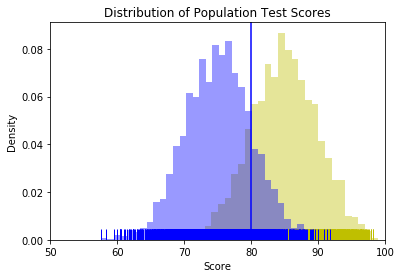

In [2]:
# Generate our population of student test scores
population_size = 5000
treatment = np.random.choice([0, 1], population_size)

# Mother Nature
treatment_effect = 10
population_scores = 75 + treatment_effect*treatment + np.random.normal(loc=0.0, scale=5.0, size=population_size)

# Plot the distribution
treatment_df = pd.DataFrame()
treatment_df["treated"] = treatment
treatment_df["score"] = population_scores

fig, ax = plt.subplots()
sns.distplot(treatment_df.loc[treatment_df['treated'] == 1, "score"], 
             kde=False, rug=True, norm_hist=True, ax=ax, color="y")
sns.distplot(treatment_df.loc[treatment_df['treated'] == 0, "score"], 
             kde=False, rug=True, norm_hist=True, ax=ax, color="b")
ax.axvline(np.mean(population_scores), 0, 1, color="b")
ax.set_xlim(50, 100)
ax.set_title("Distribution of Population Test Scores")
ax.set_xlabel("Score")
ax.set_ylabel("Density")

Here, we have created some simulated data using a test score of 75 as our population average and the effect of being in a small class being a 10 point increase in test scores. Although simulating data may seem weird at first, it  is often a great way to build intuition about new methods and their limitations. The above overlays the distributions of test scores for treated and untreated students.

Now, we can take a sample from that population and begin to explore how OLS helps us to estimate the average treatment effect of placing students into smaller classrooms.

Text(85.30139740691867, 49.4, '9.87')

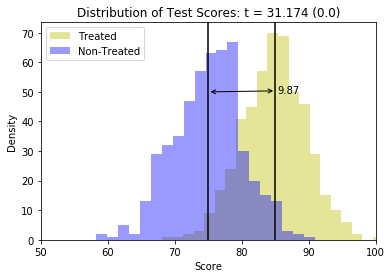

In [3]:
sample_size = 1000
student_sample = np.random.choice(treatment_df.index, replace=False, size=1000)
sample_df = treatment_df.loc[student_sample, :]


treated = sample_df.loc[sample_df["treated"] == 1, "score"]
untreated = sample_df.loc[sample_df["treated"] == 0, "score"]
sample_diff = treated.mean() - untreated.mean()
t_stat, p_val = ttest_ind(treated, untreated)

# Plot distributions in the sample
fig, ax = plt.subplots()
sns.distplot(treated, kde=False, label="Treated", ax=ax, color="y")
sns.distplot(untreated, kde=False, label="Non-Treated", ax=ax, color="b")
ax.axvline(np.mean(treated), 0, 1, color="black")
ax.axvline(np.mean(untreated), 0, 1, color="black")
ax.set_xlim(50, 100)
ax.set_title("Distribution of Test Scores: t = {} ({})".format(round(t_stat, 3), round(p_val, 3)))
ax.set_xlabel("Score")
ax.set_ylabel("Density")
ax.legend()
ax.annotate('{}'.format(round(sample_diff, 2)),
            xy=(np.mean(untreated),50), xytext=(np.mean(treated) + 0.4,49.4), 
            arrowprops=dict(arrowstyle='<->', color="black"))

The plot above shows the distributions of test scores split by treatment status. The t-stat and corresponding p value for comparing the test scores from the two groups is displayed. The displayed test uses the following set up:

- $H_0$: The test scores for treated and non-treated individuals are the same
- $H_A$: The test scores for treated and non-treated individuals are different

In [4]:
model = smf.ols(formula="score ~ 1 + treated", data=sample_df)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                     971.8
Date:                Sun, 09 Jun 2019   Prob (F-statistic):          1.60e-149
Time:                        22:33:35   Log-Likelihood:                -3028.6
No. Observations:                1000   AIC:                             6061.
Df Residuals:                     998   BIC:                             6071.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     75.0313      0.224    335.477      0.000      74.592      75.470
treated        9.8701      0.317     31.174      0.000       9.249      10.491
==============================================================================
Omnibus:                        2.953   Durbin-Watson:                   2.050
Prob(Omnibus):                  0.228   Jarque-Bera (JB):                3.096
Skew:                          -0.052   Prob(JB):                        0.213
Kurtosis:                       3.252   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

From the regression summary output, we can see that the coefficient on the treatment variable is identical to the difference in means between the two groups reporter earlier. We can also see that the z-score for the coeficient and its corresponding p-value are identical to the value of the test statistic and p value from our earlier test.

So far, we have seen that for this data-generating process, the estimate of the treatment effect from OLS is identical to simply comparing the means between the treated and untreated groups. Now that we understand the mechanics of the baseline linear model, let's consider what happens when the data generating process is more complex.

Text(0.5, 1.0, 'Distribution of Test Scores: t = 28.898 (0.0)')

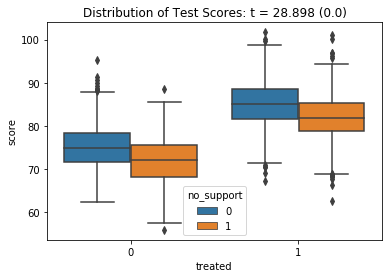

In [5]:
# Generate our population of student test scores
treatment_df["no_support"] = np.random.choice([0, 1], len(treatment_df))

# New DGP
treatment_effect = 10
no_support_effect = 3
treatment_df["score"] = (75 + 
                         treatment_effect*treatment_df["treated"] - 
                         no_support_effect*treatment_df["no_support"] + 
                         np.random.normal(loc=0.0, scale=5.0, size=population_size))


sample_size = 1000
student_sample = np.random.choice(treatment_df.index, replace=False, size=1000)
sample_df = treatment_df.loc[student_sample, :]

treated = sample_df.loc[sample_df["treated"] == 1, "score"]
untreated = sample_df.loc[sample_df["treated"] == 0, "score"]
sample_diff = treated.mean() - untreated.mean()
t_stat, p_val = ttest_ind(treated, untreated)

fig, ax = plt.subplots()
sns.boxplot(x="treated", y="score", hue="no_support", data=treatment_df, ax=ax)
ax.set_title("Distribution of Test Scores: t = {} ({})".format(round(t_stat, 3), round(p_val, 3)))

In [6]:
model = smf.ols(formula="score ~ 1 + treated ", data=sample_df)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.456
Model:                            OLS   Adj. R-squared:                  0.455
Method:                 Least Squares   F-statistic:                     835.1
Date:                Sun, 09 Jun 2019   Prob (F-statistic):          6.45e-134
Time:                        22:33:39   Log-Likelihood:                -3096.9
No. Observations:                1000   AIC:                             6198.
Df Residuals:                     998   BIC:                             6208.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     73.6223      0.237    310.503      0.000      73.157      74.088
treated        9.7984      0.339     28.898      0.000       9.133      10.464
==============================================================================
Omnibus:                        5.695   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.058   Jarque-Bera (JB):                5.681
Skew:                           0.185   Prob(JB):                       0.0584
Kurtosis:                       3.008   Cond. No.                         2.59
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Like before, fitting the treatment-only model yields an estimated ATE that is identical to running a t-test comparing the means of the treatment and control groups. However, we know that this model is wrong since we generated the data, so let's see what happens when we include familiy support as a regressor.

In [7]:
model = smf.ols(formula="score ~ 1 + treated + no_support", data=sample_df)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.505
Model:                            OLS   Adj. R-squared:                  0.504
Method:                 Least Squares   F-statistic:                     508.3
Date:                Sun, 09 Jun 2019   Prob (F-statistic):          6.48e-153
Time:                        22:33:47   Log-Likelihood:                -3049.4
No. Observations:                1000   AIC:                             6105.
Df Residuals:                     997   BIC:                             6120.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     75.1499      0.273    275.008      0.000      74.614      75.686
treated        9.8738      0.324     30.512      0.000       9.239      10.509
no_support    -3.2255      0.324     -9.966      0.000      -3.861      -2.590
==============================================================================
Omnibus:                        5.497   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.064   Jarque-Bera (JB):                5.551
Skew:                           0.181   Prob(JB):                       0.0623
Kurtosis:                       2.957   Cond. No.                         3.10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0, 0.5, 'Estimate Treatment Effect')

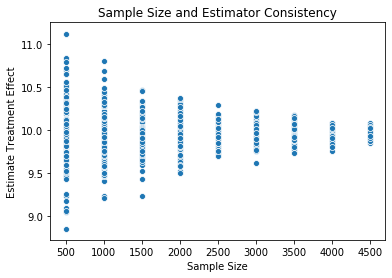

In [8]:
repeated_samples = 100
treatment_effects = []
sample_sizes = np.arange(500, 5000, 500)
x = []
y = []
for sample_size in sample_sizes:
    for i in range(repeated_samples):
        student_sample = np.random.choice(treatment_df.index, replace=False, size=sample_size)
        sample_df = treatment_df.loc[student_sample, :]
        res = smf.ols(formula="score ~ 1 + treated + no_support", data=sample_df).fit()
        x.append(sample_size)
        y.append(res.params["treated"])
        

sample_data = pd.DataFrame(zip(x, y), columns=["sample_size", "est_ate"])
mean_data = sample_data.groupby(by="sample_size").mean().reset_index()

fig, ax = plt.subplots()
sns.scatterplot(x="sample_size", y="est_ate", data=sample_data)
ax.set_title("Sample Size and Estimator Consistency")
ax.set_xlabel("Sample Size")
ax.set_ylabel("Estimate Treatment Effect")

By the central limit theorem, we know that this distribution is approximately normal for large samples. We have calcualted an emprical sampling distribution by taking 500 independent samples of 1000 students each from our population of interest.

Text(0.5, 1.0, 'Distribution of ATE for Support vs. No-Support Models')

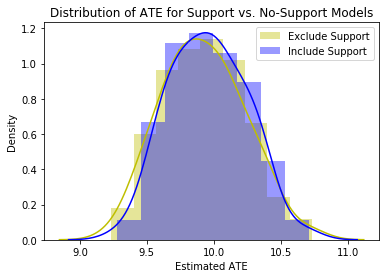

In [9]:
repeated_samples = 100 
sample_size = 1000
no_support_results = []
support_results = []
for i in range(repeated_samples):
    student_sample = np.random.choice(treatment_df.index, replace=False, size=sample_size)
    sample_df = treatment_df.loc[student_sample, :]
    res = smf.ols(formula="score ~ 1 + treated", data=sample_df).fit()
    no_support_results.append(res.params["treated"])
    res = smf.ols(formula="score ~ 1 + treated + no_support", data=sample_df).fit()
    support_results.append(res.params["treated"])

fix, ax = plt.subplots()
sns.distplot(no_support_results, color="y", ax=ax, label="Exclude Support")
sns.distplot(support_results, color="b", ax=ax, label="Include Support")
ax.set_xlabel("Estimated ATE")
ax.set_ylabel("Density")
ax.legend()
ax.set_title("Distribution of ATE for Support vs. No-Support Models")

Although the data are generated using a different process than what we specified in the model, we still get an unbiased estimate of the ATE. This is because the excluded variable (family support) is not correlated with treatment. Therefore, we are not in violation of any OLS assumptions that would result in a biased estimate. Hower, including familiy support in the model does allow us to explain more variation in the data, which in turn, results in a more precise estimate of the treatment effect (smaller standard error).

## Omitted Variable Bias

We now consider the case where a variable is omitted from our model that plays a role in determining test scores and is also correlated with treatment. When such a variable exists and is omitted from our causal model, the estimated treatement effect will be biased. This is cleaverly entitled **omitted variable bias**. Including the variable in our model (if possible) is a way to eliminate this bias. More generally, multiple regression can be seen as a way to circumvent omitted variable bias if we include any and all variables that we believe (from subject matter or theoretical grounds) are important determinants of the outcome we care about.

In [18]:
from scipy.linalg import cholesky
from sklearn.preprocessing import minmax_scale, scale


# Generate some correlated random data in [0, 1]
corr_mat = np.array([
    [1.0, 0.8],
    [0.8, 1.0]
])

upper_cholesky = cholesky(corr_mat)
random_data = np.random.normal(0, 1, size=(population_size, 2))
transformed_data = random_data @ upper_cholesky

# Create a no_support dummy using 0.5 threshold
no_support = minmax_scale(transformed_data [:, 0], feature_range=(0,1))
no_support = [1 if s < 0.5 else 0 for s in no_support]

# Normalize income to be between 0 and 100K
normalized_income = transformed_data[:, 1]
income = 100000*((normalized_income - normalized_income.min()) / (normalized_income.max() - normalized_income.min()))


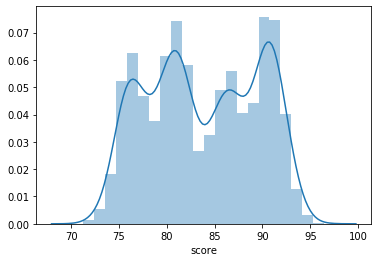

In [23]:
treatment_df["income"] = income
treatment_df["no_support"] = no_support


treatment_effect = 10
no_support_effect = 3
income_effect = .0001
treatment_df["score"] = (75 + 
                         treatment_effect*treatment_df["treated"] - 
                         no_support_effect*treatment_df["no_support"] + 
                         income_effect*treatment_df["income"] +
                         np.random.normal(loc=0.0, scale=1.0, size=population_size))


sample_size = 1000
student_sample = np.random.choice(treatment_df.index, replace=False, size=sample_size)
sample_df = treatment_df.loc[student_sample, :]

treated = sample_df.loc[sample_df["treated"] == 1, "score"]
untreated = sample_df.loc[sample_df["treated"] == 0, "score"]
sample_diff = treated.mean() - untreated.mean()
t_stat, p_val = ttest_ind(treated, untreated)
t_stat, p_val


sns.distplot(treatment_df["score"])

In [26]:
model = smf.ols(formula="score ~ 1 + treatment + no_support", data=treatment_df)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                 3.737e+04
Date:                Sun, 09 Jun 2019   Prob (F-statistic):               0.00
Time:                        23:06:59   Log-Likelihood:                -8890.4
No. Observations:                5000   AIC:                         1.779e+04
Df Residuals:                    4997   BIC:                         1.781e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     80.9056      0.034   2399.652      0.000      80.839      80.972
treatment      9.9441      0.041    245.326      0.000       9.865      10.024
no_support    -4.6774      0.041   -114.128      0.000      -4.758      -4.597
==============================================================================
Omnibus:                        1.965   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.374   Jarque-Bera (JB):                1.965
Skew:                          -0.019   Prob(JB):                        0.374
Kurtosis:                       3.089   Cond. No.                         3.07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
model = smf.ols(formula="score ~ 1 + treatment + no_support + income", data=treatment_df)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                 5.234e+04
Date:                Sun, 09 Jun 2019   Prob (F-statistic):               0.00
Time:                        23:07:09   Log-Likelihood:                -7117.5
No. Observations:                5000   AIC:                         1.424e+04
Df Residuals:                    4996   BIC:                         1.427e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     74.8756      0.087    858.324      0.000      74.705      75.047
treatment      9.9501      0.028    349.905      0.000       9.894      10.006
no_support    -2.9814      0.037    -80.129      0.000      -3.054      -2.908
income         0.0001   1.43e-06     71.813      0.000    9.97e-05       0.000
==============================================================================
Omnibus:                        1.942   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.379   Jarque-Bera (JB):                1.955
Skew:                          -0.030   Prob(JB):                        0.376
Kurtosis:                       2.925   Cond. No.                     3.44e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.44e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Comparing the two models above, we can see that the estimated treatment effect is comparable. However, the specification that excludes income results is a much larger (in absolute terms) coefficient on the effect of no family support than the specification that includes income as a predictor. This is due to the fact that family support and income are highly correlated: higher family income increases the probability of family support. Therefore, by excluding income from our model, the effect of income on test scores is (at least partially) incorrectly attributed to not having family support.

This example consider an omitted variable that was correlated with an explanatory variable that was not the treatment variable. The same logic anc consequences result if the omitted variable is correlated with treatment. In the section section, we will consider a technique for handling the general problem of having one or more regresors that are correlated with the error term.

Text(0.5, 1.0, 'Distribution of ATE for Income vs. No-Income Models')

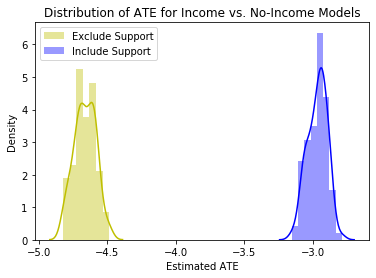

In [31]:
repeated_samples = 100 
sample_size = 1000
no_income_results = []
income_results = []
for i in range(repeated_samples):
    student_sample = np.random.choice(treatment_df.index, replace=False, size=sample_size)
    sample_df = treatment_df.loc[student_sample, :]
    res = smf.ols(formula="score ~ 1 + treated + no_support", data=sample_df).fit()
    no_income_results.append(res.params["no_support"])
    res = smf.ols(formula="score ~ 1 + treated + no_support + income", data=sample_df).fit()
    income_results.append(res.params["no_support"])

fix, ax = plt.subplots()
sns.distplot(no_support_results, color="y", ax=ax, label="Exclude Support")
sns.distplot(support_results, color="b", ax=ax, label="Include Support")
ax.set_xlabel("Estimated ATE")
ax.set_ylabel("Density")
ax.legend()
ax.set_title("Distribution of ATE for Income vs. No-Income Models")

In [47]:
repeated_samples = 100 
sample_size = 1000
no_income_results = []
x = []
y = []
sample_sizes = np.arange(500, 5000, 500)

for sample_size in sample_sizes:
    for i in range(repeated_samples):
        student_sample = np.random.choice(treatment_df.index, replace=False, size=sample_size)
        sample_df = treatment_df.loc[student_sample, :]
        
        res_no_income = smf.ols(formula="score ~ 1 + treated + no_support", data=sample_df).fit()
        res_income = smf.ols(formula="score ~ 1 + treated + no_support + income", data=sample_df).fit()
        x.append(sample_size)
        y.append((res_no_income.params["no_support"] - res_income.params["no_support"]))

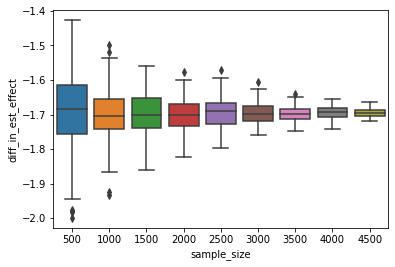

In [48]:
df = pd.DataFrame()
df["sample_size"] = x
df["diff_in_est_effect"] = y

fig, ax = plt.subplots()
sns.boxplot(x="sample_size", y="diff_in_est_effect",  data=df, ax=ax)

The boxplot above shows the difference in the estimated coefficient of no family support for a model that includes family income and a model that does not include family income. If there were no omitted variable bias, this difference should concetrate around zero and become tighter as the sample size gets larger. Clearly, the estimated coefficient is biased downward by not including income as a regeressor. The important point to this plot is that bias is independent of sample size. No amount of additional data will correct for an incorrect model.